# Knapsack Implementation on Qiskit

Some sections of the code have been obtained from the contents on: 

In [38]:
#Required Libraries
import random
from qiskit_optimization.translators import from_docplex_mp
from qiskit_optimization import QuadraticProgram
from docplex.mp.model import Model
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit.circuit.library.n_local.qaoa_ansatz import QAOAAnsatz
from qiskit.circuit import Parameter, ParameterVector
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator 
import numpy as np
from scipy.optimize import minimize
from qiskit.visualization import plot_distribution
import plotly.graph_objects as go

## 1. Parameter Selection
Choose the desired parameters to configure the creation of a Knapsack Algorithm
- Seed for the random value generation
- num_items for the total number of items to be generate
- total_weight for the threshold value of the sum of items the Knapsack can carry
- max_weight for the maximum value range the items can have. If none, it is set to the total_weight

In [131]:
seed = 123
num_items = 4
total_weight = 25
max_price = 50
max_weight = 50

if max_weight is None: max_weight = total_weight

In [132]:
def create_knapsack(n, maximum_weight, maximum_value, rand_seed: int = None) -> dict:
    """
    Creates knapsack list of items using random number generator
    
    :param n: Number of knapsack items
    :param maximum_weight: Maximum value of the knapsack items
    :param maximum_value: Maximum value of the knapsack items
    :param rand_seed: Seed for the random number generator
    :return: List of knapsack items, each of them with weight as the first parameter and value as the second parameter
    """
    item_list = {}
    random.seed(rand_seed)
    for i in range(n):
        item_list[i] = (random.randint(1, maximum_weight), random.randint(1, maximum_value))
    
    return item_list

## 2. Create Knapsack

In [133]:
items = create_knapsack(num_items, max_weight if max_weight is not None else total_weight, max_price if max_price is not None else total_weight, rand_seed=seed)
print("Knapsack created:")
print("Items:", list(items.values()))
print("Total weight:", total_weight)

Knapsack created:
Items: [(4, 18), (6, 50), (27, 18), (7, 3)]
Total weight: 25


## 3. Define the Quadratic Program

In [134]:
def knapsack_to_quadratic_program(items, maximum) -> QuadraticProgram:
    """
    Convert a knapsack problem from arguments into a Quadratic Program
    
    :param items: dictionary with items, where keys are item names and values are tuples of (weight, value)
    :param maximum: maximum weight of the knapsack problem
    :return: The Quadratic Program created from the knapsack problem.
    """
    mdl = Model(name="Knapsack")
    
    # Variable Creation
    weights = [w for w, v in items.values()]
    values = [v for w, v in items.values()]
    
    x = {i: mdl.binary_var(name=f"x_{i}") for i in range(len(values))}
    
    # Objective Function Definition
    mdl.maximize(mdl.sum(values[i] * x[i] for i in x))
    
    # Add constraint of total weights supported
    mdl.add_constraint(mdl.sum(weights[i] * x[i] for i in x) <= maximum)
    
    quadratic_program = from_docplex_mp(mdl)
    return quadratic_program

In [135]:
from qiskit_optimization.applications import Knapsack

qp = knapsack_to_quadratic_program(items, max_weight)
print(qp.prettyprint())

'''
values = []
weights = []
for item in items.values():
    values.append(item[1])
    weights.append(item[0])
    
qp = Knapsack(values=values, weights=weights, max_weight=max_weight).to_quadratic_program()
print(qp.prettyprint())
'''

Problem name: Knapsack

Maximize
  18*x_0 + 50*x_1 + 18*x_2 + 3*x_3

Subject to
  Linear constraints (1)
    4*x_0 + 6*x_1 + 27*x_2 + 7*x_3 <= 50  'c0'

  Binary variables (4)
    x_0 x_1 x_2 x_3



'\nvalues = []\nweights = []\nfor item in items.values():\n    values.append(item[1])\n    weights.append(item[0])\n    \nqp = Knapsack(values=values, weights=weights, max_weight=max_weight).to_quadratic_program()\nprint(qp.prettyprint())\n'

## 4. Convert to QUBO

In [136]:
qp2qubo = QuadraticProgramToQubo()
qubo = qp2qubo.convert(qp)
print("QUBO:", qubo.prettyprint())
qubitOp, offset = qubo.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

QUBO: Problem name: Knapsack

Minimize
  90*c0@int_slack@0^2 + 360*c0@int_slack@0*c0@int_slack@1
  + 720*c0@int_slack@0*c0@int_slack@2 + 1440*c0@int_slack@0*c0@int_slack@3
  + 2880*c0@int_slack@0*c0@int_slack@4 + 3420*c0@int_slack@0*c0@int_slack@5
  + 360*c0@int_slack@1^2 + 1440*c0@int_slack@1*c0@int_slack@2
  + 2880*c0@int_slack@1*c0@int_slack@3 + 5760*c0@int_slack@1*c0@int_slack@4
  + 6840*c0@int_slack@1*c0@int_slack@5 + 1440*c0@int_slack@2^2
  + 5760*c0@int_slack@2*c0@int_slack@3 + 11520*c0@int_slack@2*c0@int_slack@4
  + 13680*c0@int_slack@2*c0@int_slack@5 + 5760*c0@int_slack@3^2
  + 23040*c0@int_slack@3*c0@int_slack@4 + 27360*c0@int_slack@3*c0@int_slack@5
  + 23040*c0@int_slack@4^2 + 54720*c0@int_slack@4*c0@int_slack@5
  + 32490*c0@int_slack@5^2 + 720*x_0*c0@int_slack@0 + 1440*x_0*c0@int_slack@1
  + 2880*x_0*c0@int_slack@2 + 5760*x_0*c0@int_slack@3 + 11520*x_0*c0@int_slack@4
  + 13680*x_0*c0@int_slack@5 + 1440*x_0^2 + 4320*x_0*x_1 + 19440*x_0*x_2
  + 5040*x_0*x_3 + 1080*x_1*c0@int_

## 5. Create QAOA Circuit

Write a function that takes as input a quadratic program and a parameter $p$, and produces as output the corresponding QAOA circuit with $p$ layers.The basic construct of the function is provided below, but you will have to insert the parts where the cost and mixer layers are applied.You will need to calculate the angles of the rotational gates as described in the final equations above.In the code below, we refer to the qubo matrix $Q$ as `qubo_matrix`, and to the vector $c$ as `qubo_linearity`.Make sure not to include any measurements in the circuit.

In [137]:
def qaoa_circuit_conversion(qubo_program: QuadraticProgram, p: int = 1):
    """
    Given a QUBO instance and the number of layers p, constructs the corresponding parameterized QAOA circuit with p layers.
    Args:
        qubo: The quadratic program instance
        p: The number of layers in the QAOA circuit
    Returns:
        The parameterized QAOA circuit
    """
    size = qubo_program.get_num_vars()
    operator, value = qubo_program.to_ising()
    
    qaoa_circuit = QAOAAnsatz(cost_operator=operator, reps=p)
    #parameters = [Parameter(f'γ_{i}') for i in range(p)] + [Parameter(f'β_{i}') for i in range(p)]
    #qaoa_circuit.assign_parameters(parameters, inplace=True)

    
    return qaoa_circuit

In [157]:
circuit = qaoa_circuit_conversion(qubo, p=1)
##circuit.decompose().decompose().decompose().draw('mpl')

## 6. Hardware Execution

In [158]:
service = QiskitRuntimeService(channel="ibm_quantum")

# To execute in real hardware, set this variable to true!
RUN_MODE = False

if RUN_MODE:
    # To run on hardware, select the backend with the fewest number of jobs in the queue
    backend = service.least_busy(operational=True, simulator=False)
else:
    real_backend = service.backend("ibm_brisbane")
    backend = AerSimulator.from_backend(real_backend)

pm = generate_preset_pass_manager(backend=backend, optimization_level=3)

In [159]:
# Ansatz Optimization
ansatz_isa = pm.run(circuit)
#

In [160]:
ansatz_isa.decompose().decompose().decompose().draw(output="mpl", idle_wires=False, style="iqp")

ValueError: Image size of 2228x68928 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 2228.98x68929 with 1 Axes>

In [161]:
# ISA Observables
hamiltonian, _ = qubo.to_ising()
hamiltonian_isa = hamiltonian.apply_layout(ansatz_isa.layout)
print(hamiltonian_isa)

SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIII

In [162]:
# Executing Qiskit Primitives
session = Session(backend=backend)

# Configure estimator
estimator = Estimator(session=session)
estimator.options.default_shots = 100000
estimator.options.dynamical_decoupling.enable = True

# Configure sampler
sampler = Sampler(session=session)
sampler.options.default_shots = 1000000
sampler.options.dynamical_decoupling.enable = True

C:\Users\guill\PycharmProjects\qiskitTesting\.venv\Lib\site-packages\qiskit_ibm_runtime\session.py:157: UserWarning:

Session is not supported in local testing mode or when using a simulator.



### 6.1 Cost Function

In [163]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    cost = result[0].data.evs[0]

    return cost

### 6.2 Callback

In [164]:
def build_callback(ansatz, hamiltonian, estimator, callback_dict):
    """Return callback function that uses Estimator instance,
    and stores intermediate values into a dictionary.

    Parameters:
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        callback_dict (dict): Mutable dict for storing values

    Returns:
        Callable: Callback function object
    """

    def callback(current_vector):
        """Callback function storing previous solution vector,
        computing the intermediate cost value, and displaying number
        of completed iterations and average time per iteration.

        Values are stored in pre-defined 'callback_dict' dictionary.

        Parameters:
            current_vector (ndarray): Current vector of parameters
                                      returned by optimizer
        """
        # Keep track of the number of iterations
        callback_dict["iters"] += 1
        # Set the prev_vector to the latest one
        callback_dict["prev_vector"] = current_vector
        # Compute the value of the cost function at the current vector
        # This adds an additional function evaluation
        pub = (ansatz, [hamiltonian], [current_vector])
        result = estimator.run(pubs=[pub]).result()
        current_cost = result[0].data.evs[0]
        callback_dict["cost_history"].append(current_cost)
        # Print to screen on single line
        print(
            "Iters. done: {} [Current cost: {}]".format(callback_dict["iters"], current_cost),
            end="\r",
            flush=True,
        )

    return callback

callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

### 6.3 Estimate

In [165]:
x0 = 2 * np.pi * np.random.rand(ansatz_isa.num_parameters)
print("Starting point: ", x0)

Starting point:  [5.40609347 4.96996042]


In [166]:
# SciPy minimizer routine
# Initial Parameters


with Session(backend=backend) as session:
    estimator = Estimator(session=session)
    estimator.options.default_shots = 10000

    callback = build_callback(ansatz_isa, hamiltonian_isa, estimator, callback_dict)

    res = minimize(
        cost_func,
        x0,
        args=(ansatz_isa, hamiltonian_isa, estimator),
        method="COBYLA",
        callback=callback
    )

C:\Users\guill\PycharmProjects\qiskitTesting\.venv\Lib\site-packages\qiskit_ibm_runtime\fake_provider\local_service.py:243: UserWarning:

Options {'default_shots': 10000} have no effect in local testing mode.



### 6.4 ISA Conversion

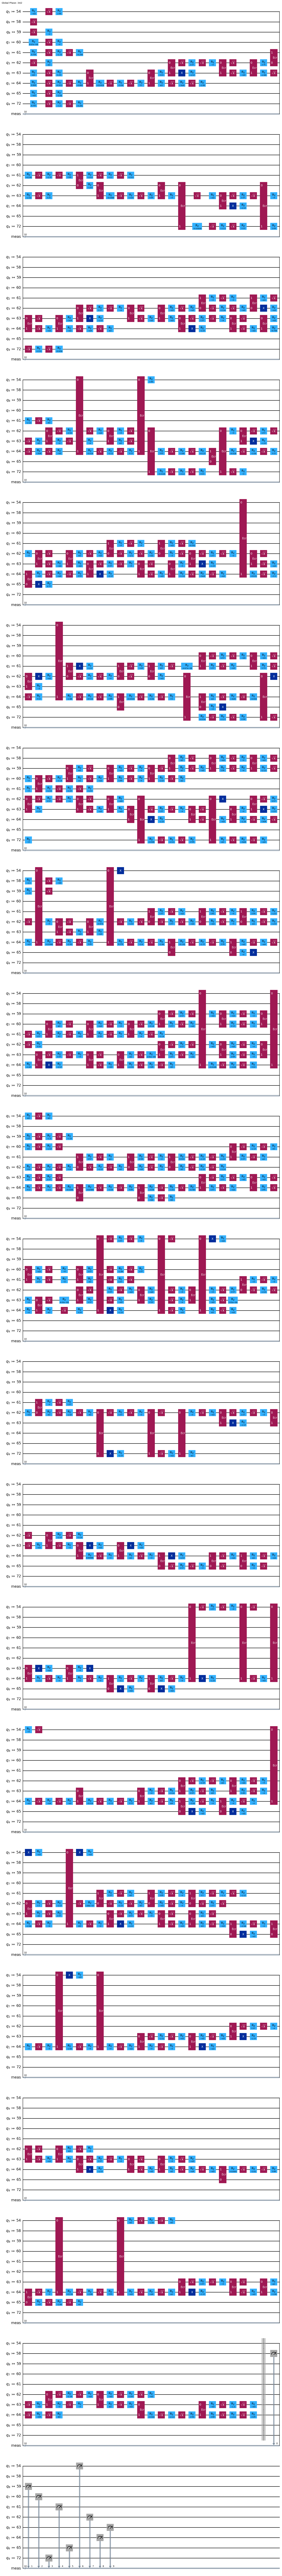

In [167]:
# Assign solution parameters to ansatz
qc = circuit.assign_parameters(res.x)

# Add measurements to our circuit
qc.measure_all()
qc_isa = pm.run(qc)
qc_isa.draw(output="mpl", idle_wires=False, style="iqp")

### 6.5 Sampling

In [168]:
result = sampler.run([qc_isa]).result()
samp_dist = result[0].data.meas.get_counts()
# Close the session since we are now done with it
session.close()

C:\Users\guill\PycharmProjects\qiskitTesting\.venv\Lib\site-packages\qiskit_ibm_runtime\fake_provider\local_service.py:243: UserWarning:

Options {'dynamical_decoupling': {'enable': True}} have no effect in local testing mode.



In [169]:
plot_distribution(samp_dist, figsize=(300, 30))

In [170]:
print(result)

PrimitiveResult([PubResult(data=DataBin<>(meas=BitArray(<shape=(), num_shots=1000000, num_bits=10>)))], metadata={})


## 7. Post-Processing

In [171]:
def bitstring_to_cost(bitstring, items, max_weight):
    """
    Calculate the cost from a bitstring solution for the Knapsack problem.
    
    :param bitstring: the bitstring solution representing selected items
    :param items: dictionary with items, where keys are item names and values are tuples of (weight, value)
    :param max_weight: maximum weight capacity of the knapsack
    :return: the total value of the selected items if within the weight limit, otherwise a penalty value
    """
    weights = []
    values = []
    for i in items.values():
        weights.append(i[0])
        values.append(i[1])
    
    total_weight = 0
    total_value = 0
    
    for i, bit in enumerate(bitstring):
        if bit == '1':
            total_weight += weights[i]
            total_value += values[i]
    
    if total_weight > max_weight:
        return -1  # Penalty for exceeding the weight limit
    else:
        return total_value

In [172]:
def bitstring_to_items(bitstring, items):
    """
    Convert a bitstring solution to a list of selected items for the Knapsack problem.
    
    :param bitstring: the bitstring solution representing selected items
    :param items: dictionary with items, where keys are item names and values are tuples of (weight, value)
    :return: list of selected items
    """
    selected_items = []
    item_names = list(items.keys())
    
    for i, bit in enumerate(bitstring):
        if bit == '1':
            selected_items.append(item_names[i])
    
    return selected_items


In [173]:
def plot_samples(samples):
    """
    Plots a bar diagram for the samples of a quantum algorithm
    Args:
        samples
    """
    #Sort samples by probability
    samples = sorted(samples.items(), key=lambda kv: kv[1])

    # Reinterpret the bitstrings back to the original layout
    bitstrings = []
    bitstring_lists = []
    for sample in samples:
        vars = []
        # Invert the bitstring because the results are inverted!
        for char in sample[0][::-1]:
            vars.append(int(char))
        bitstring_lists.append(qp2qubo.interpret(vars).tolist())
        #print(bitstring_lists[0])
        bitstrings.append("".join(map(str, map(int, qp2qubo.interpret(vars).tolist()))))
        
    #Get list of probabilities and function values
    probabilities = [sample[1] for sample in samples]
    
    # Interpret the bitstrings back to the original shape
    values = [bitstring_to_cost(bitstring, items, max_weight) for bitstring in bitstrings]
    alt_values = [qp.objective.evaluate(item) for item in bitstring_lists]
    
    # Group bitstrings
    unique_bitstrings = []
    total_probs = []
    unique_values = []
    unique_alt_values = []
    for index, bit_string in enumerate(bitstrings): 
        if bit_string not in unique_bitstrings: 
            unique_bitstrings.append(bit_string)
            unique_values.append(values[index])
            unique_alt_values.append(alt_values[index])
            total_probs.append(0)
        total_probs[unique_bitstrings.index(bit_string)] += probabilities[index]

    #Plot bar diagram for frequency
    sample_plot = go.Bar(x = unique_bitstrings, y = total_probs, marker=dict(color=unique_values, colorscale = 'plasma',colorbar=dict(title='Function Value')))
    fig = go.Figure(
        data=sample_plot, 
        layout = dict(
            xaxis=dict(
                type = 'category'
            )
        )
    )
    fig.update_layout(barmode='stack', xaxis={'categoryorder':'total ascending'})
    fig.show()


        
    #print (unique_bitstrings, total_probs, unique_values)
    #Plot bar diagram for cost
    sample_plot = go.Bar(x = unique_bitstrings, y = total_probs, marker=dict(color=unique_alt_values, colorscale = 'solar',colorbar=dict(title='Function Value')))
    fig = go.Figure(
        data=sample_plot, 
        layout = dict(
            xaxis=dict(
                type = 'category'
            )
        )
    )
    fig.update_layout(barmode='stack', xaxis={'categoryorder':'total ascending'})
    fig.show()

In [174]:
plot_samples(samp_dist)
#print(samp_dist)

In [175]:
# Assuming samp_dist is a dictionary with bitstrings as keys and their counts as values
samples = list(sorted(samp_dist.items(), key=lambda kv: kv[1]))

samps = []

for sample in samples:
    vars = []
    # Invert the bitstring because the results are inverted!
    for char in sample[0][::-1]:
        vars.append(int(char))
        
    bitstring = "".join(map(str, map(int, qp2qubo.interpret(vars).tolist())))
    
    cost = bitstring_to_cost(bitstring, items, max_weight)
    samps.append([bitstring, sample[1], cost])

samps.sort(key=lambda kv: kv[0])  # Sort by cost

for sample in samps:
    bitstring, count, cost = sample
    selected_items = bitstring_to_items(bitstring, items)
    print(f"Cost: {cost}, from String: {bitstring}, with selected item: {selected_items}")

Cost: 0, from String: 0000, with selected item: []
Cost: 0, from String: 0000, with selected item: []
Cost: 0, from String: 0000, with selected item: []
Cost: 0, from String: 0000, with selected item: []
Cost: 0, from String: 0000, with selected item: []
Cost: 0, from String: 0000, with selected item: []
Cost: 0, from String: 0000, with selected item: []
Cost: 0, from String: 0000, with selected item: []
Cost: 0, from String: 0000, with selected item: []
Cost: 0, from String: 0000, with selected item: []
Cost: 0, from String: 0000, with selected item: []
Cost: 0, from String: 0000, with selected item: []
Cost: 0, from String: 0000, with selected item: []
Cost: 0, from String: 0000, with selected item: []
Cost: 0, from String: 0000, with selected item: []
Cost: 0, from String: 0000, with selected item: []
Cost: 0, from String: 0000, with selected item: []
Cost: 0, from String: 0000, with selected item: []
Cost: 0, from String: 0000, with selected item: []
Cost: 0, from String: 0000, wit